In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import cfg
import mlflow
from IPython.display import display

In [2]:
os.chdir(cfg.WORKDIR)

In [3]:
_ = mlflow.set_experiment(cfg.MLFLOW_DEFAULT_EXPERIMENT)

In [4]:
raw_result = mlflow.search_runs()

In [5]:
metrics_col = [f for f in raw_result.columns if f.startswith('metrics.')]
parameters_col = [f for f in raw_result.columns if f.startswith('params.')]

In [6]:
to_keep =  ['tags.mlflow.runName'] + metrics_col + parameters_col
exp_result = raw_result[to_keep].copy()
exp_result = exp_result.rename(columns={f: f.replace('metrics.', '') for f in metrics_col})
exp_result = exp_result.rename(columns={f: f.replace('params.', '') for f in parameters_col})
exp_result = exp_result.rename(columns={'tags.mlflow.runName': 'experiment_name'})

In [7]:
exp_result

,experiment_name,valid_auc,valid_logloss,train_logloss,train_auc,n_input_features,model,C,dataset_name,max_iter,colsample_bytree,max_depth,n_estimators,eta,subsample
0,freq_encoding-logreg,0.621181,0.152951,0.152732,0.627175,57,logreg,0.1,freq_encoding,2000,None,None,None,None,None
1,freq_encoding-xgb,0.635247,0.152072,0.150761,0.656456,57,xgb,None,freq_encoding,None,0.8,4,100,0.08,0.8
2,one_hot_encoding-logreg,0.626538,0.152604,0.152002,0.637845,227,logreg,0.1,one_hot_encoding,2000,None,None,None,None,None
3,one_hot_encoding-xgb,0.635228,0.152068,0.150681,0.657571,227,xgb,None,one_hot_encoding,None,0.8,4,100,0.08,0.8
4,label_encoding-logreg,0.618296,0.153261,0.152985,0.625239,57,logreg,0.1,label_encoding,2000,None,None,None,None,None
5,label_encoding-xgb,0.634156,0.152149,0.150751,0.656653,57,xgb,None,label_encoding,None,0.8,4,100,0.08,0.8


In [8]:
exp_result['perc_gap'] = (exp_result['valid_logloss'] - exp_result['train_logloss']) / exp_result['train_logloss']

In [9]:
flat_scores_table = exp_result.copy()

In [10]:
flat_scores_table = pd.melt(
    exp_result,
    id_vars=['experiment_name', 'dataset_name', 'model'],
    value_vars=['train_logloss', 'valid_logloss'],
    value_name='logloss',
    var_name='_type',
)

flat_scores_table['set_type'] = flat_scores_table['_type'].str.replace('_logloss', '')

flat_scores_table.head()

flat_scores_table = flat_scores_table.sort_values(by=['model', 'dataset_name'])

,dataset_name,train_logloss,valid_logloss,perc_gap
2,one_hot_encoding,0.152002,0.152604,0.003961
0,freq_encoding,0.152732,0.152951,0.001439
4,label_encoding,0.152985,0.153261,0.001801


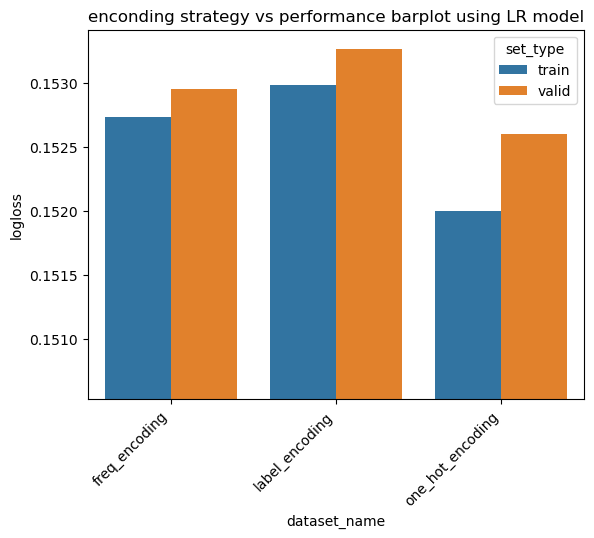

In [11]:
flat_logreg_scores = flat_scores_table[flat_scores_table['model'] == 'logreg']
logreg_result = exp_result[exp_result['model'] == 'logreg']

height = 0.001
logloss_y_limits = (exp_result['train_logloss'].min() * (1-height), exp_result['valid_logloss'].max() * (1 + height)) 

logregranking = logreg_result[['dataset_name', 'train_logloss', 'valid_logloss', 'perc_gap']].sort_values(by='valid_logloss')

display(logregranking)

f, ax = plt.subplots()
sns.barplot(
    x='dataset_name',
    y='logloss',
    hue='set_type',
    data=flat_logreg_scores,
    ax=ax,
)

ax.set_ylim(*logloss_y_limits)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('enconding strategy vs performance barplot using LR model');

,dataset_name,train_logloss,valid_logloss,perc_gap
3,one_hot_encoding,0.150681,0.152068,0.009203
1,freq_encoding,0.150761,0.152072,0.008696
5,label_encoding,0.150751,0.152149,0.009272


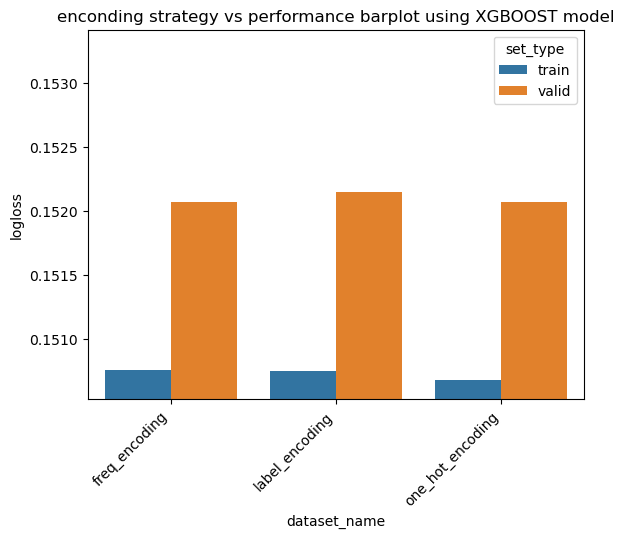

In [12]:
flat_xgb_scores = flat_scores_table[flat_scores_table['model'] == 'xgb']
xgb_result = exp_result[exp_result['model'] == 'xgb']

height = 0.001
logloss_y_limits = (exp_result['train_logloss'].min() * (1-height), exp_result['valid_logloss'].max() * (1 + height)) 

xgbranking = xgb_result[['dataset_name', 'train_logloss', 'valid_logloss', 'perc_gap']].sort_values(by='valid_logloss')

display(xgbranking)

f, ax = plt.subplots()
sns.barplot(
    x='dataset_name',
    y='logloss',
    hue='set_type',
    data=flat_xgb_scores,
    ax=ax,
)

ax.set_ylim(*logloss_y_limits)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('enconding strategy vs performance barplot using XGBOOST model');

,experiment_name,train_logloss,valid_logloss,perc_gap
3,one_hot_encoding-xgb,0.150681,0.152068,0.009203
1,freq_encoding-xgb,0.150761,0.152072,0.008696
5,label_encoding-xgb,0.150751,0.152149,0.009272
2,one_hot_encoding-logreg,0.152002,0.152604,0.003961
0,freq_encoding-logreg,0.152732,0.152951,0.001439
4,label_encoding-logreg,0.152985,0.153261,0.001801


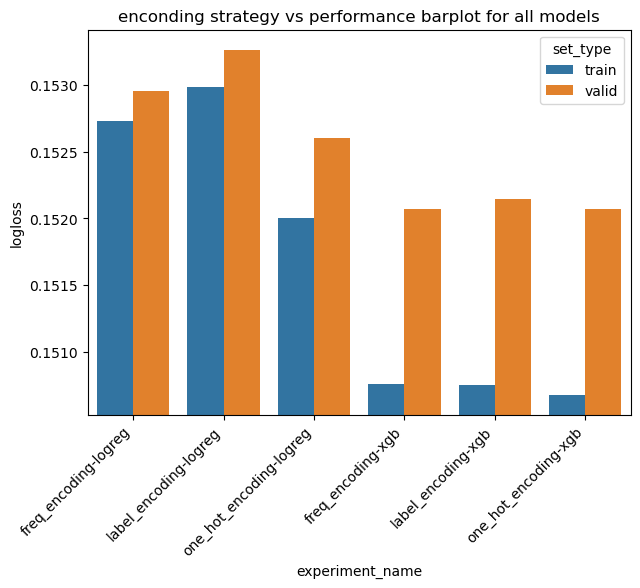

In [13]:
height = 0.001
logloss_y_limits = (exp_result['train_logloss'].min() * (1-height), exp_result['valid_logloss'].max() * (1 + height)) 

global_ranking = exp_result[['experiment_name', 'train_logloss', 'valid_logloss', 'perc_gap']].sort_values(by='valid_logloss')

display(global_ranking)

f, ax = plt.subplots(figsize=(7, 5))
sns.barplot(
    x='experiment_name',
    y='logloss',
    hue='set_type',
    data=flat_scores_table,
    ax=ax,
)


ax.set_ylim(*logloss_y_limits)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('enconding strategy vs performance barplot for all models');